In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from collections import Counter 
from tqdm import tqdm

from swarm_sim import *

%matplotlib inline 

In [2]:
NB_NODES = 50
REVOLUTION = 1800 # Number of data rows
CONNECTION_RANGE = 30 # km
SAMPLE_STEP = 12

In [5]:
df_rnd = pd.read_csv('..\output\data\sat50_varcoefs_RND_sampled12_rep30.csv', sep=',', index_col='Unnamed: 0')
df_mirw = pd.read_csv('..\output\data\sat50_varcoefs_MIRW_sampled12_rep30.csv', sep=',', index_col='Unnamed: 0')
df_ffd = pd.read_csv('..\output\data\sat50_varcoefs_FFD_sampled12_rep30.csv', sep=',', index_col='Unnamed: 0')

df_rnd = df_rnd.groupby('Timestamp').mean()
df_mirw = df_mirw.groupby('Timestamp').mean()
df_ffd = df_ffd.groupby('Timestamp').mean()

In [6]:
df_mirw.head()

,VC AD,VC ACC,VC ABC
Timestamp,,,
0,0.342681,0.246280,0.689344
12,0.346353,0.248990,0.659403
24,0.349416,0.269883,0.705742
36,0.352180,0.262978,0.767962
48,0.348867,0.279465,0.758786


In [33]:
rmse = pd.read_csv('..\output\data\sat50_RMSE_RND_sampled12_rep10.csv', sep=',', index_col='Unnamed: 0')
rmse = rmse.groupby('Nb groups').mean()
rmse

,Timestamp,RMSE AD,RMSE ACC
Nb groups,,,
1,894.0,0.000000,0.000000
2,894.0,0.804726,0.033137
3,894.0,0.997366,0.052730
4,894.0,1.761268,0.064595
5,894.0,2.103111,0.078530
6,894.0,2.106878,0.089840
7,894.0,2.551596,0.098662
8,894.0,2.674378,0.114359
9,894.0,2.959185,0.126578


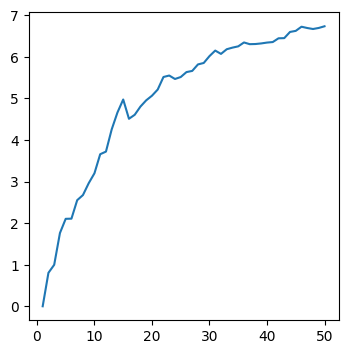

In [34]:
plt.figure(figsize=(4,4))
plt.plot(rmse['RMSE AD'])

In [18]:
df_rnd['Average'] = df_rnd.mean(axis=1)
df_mirw['Average'] = df_mirw.mean(axis=1)
df_ffd['Average'] = df_ffd.mean(axis=1)

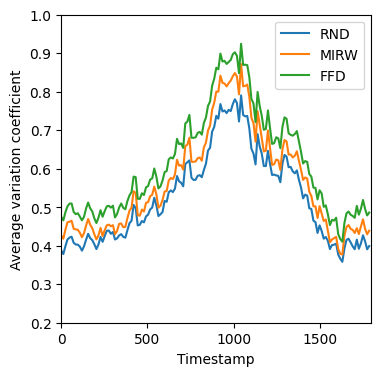

In [29]:
plt.figure(figsize=(4,4))
idx = np.arange(0, REVOLUTION, SAMPLE_STEP)

col = 'Average' # variation coefficient of metric
plt.plot(idx, df_rnd[col], label='RND')
plt.plot(idx, df_mirw[col], label='MIRW')
plt.plot(idx, df_ffd[col], label='FFD')

plt.xlabel('Timestamp')
plt.ylabel('Average variation coefficient')
plt.xlim(0,REVOLUTION)
plt.ylim(0.2,1)
plt.legend()

In [28]:
df = pd.read_csv('..\output\data\sat50_varcoefs_MIRW_sampled12_rep30.csv', sep=',', index_col='Unnamed: 0')
df.tail()

,Timestamp,VC AD,VC ACC,VC ABC
224995,1740,0.455173,0.292942,1.168464
224996,1752,0.454515,0.256265,1.296821
224997,1764,0.459183,0.310762,1.130168
224998,1776,0.466533,0.338328,1.010641
224999,1788,0.474591,0.342602,1.046177


In [6]:
def variance(data, mean=None):
    if mean == None:
        mean = np.mean(data)
    return np.mean([(d - mean)**2 for d in data])

def variation_coef(data, mean=None):
    if mean != 0:
        var = variance(data, mean)
        return np.sqrt(var)/mean
    print('Error: mean is null.')
    return -1

## 1. Analysis of Network Size

Variation coefficient of Network Size depending on NB_GROUPS:
 * RND:     VC(10) = 0.42
 * MIRW:    VC(10) = 0
 * FFD:     VC(10) = 0.97

In [7]:
NB_REPETITIONS = 30

In [9]:
nb_groups = np.arange(1,NB_NODES+1)
varcoefs_rnd = []
varcoefs_mirw = []
varcoefs_ffd = []

for nb in nb_groups:
    ref_ns = NB_NODES/nb
    
    ns = []
    for rep in range(NB_REPETITIONS):
        swarm_data[0].reset_groups()
        groups = swarm_data[0].RND(n=nb, s=rep+1, by_id=True)# <==================== ALGO CHOICE 
        ns.extend([len(group) for group in groups.values()])
    varcoefs_rnd.append(variation_coef(ns, ref_ns))
    
    ns = []
    for rep in range(NB_REPETITIONS):
        swarm_data[0].reset_groups()
        groups = swarm_data[0].MIRW(n=nb, s=rep+1, by_id=True)# <==================== ALGO CHOICE 
        ns.extend([len(group) for group in groups.values()])
    varcoefs_mirw.append(variation_coef(ns, ref_ns))
    
    ns = []
    for rep in range(NB_REPETITIONS):
        swarm_data[0].reset_groups()
        groups = swarm_data[0].FFD(n=nb, s=rep+1, by_id=True)# <==================== ALGO CHOICE 
        ns.extend([len(group) for group in groups.values()])
    varcoefs_ffd.append(variation_coef(ns, ref_ns))

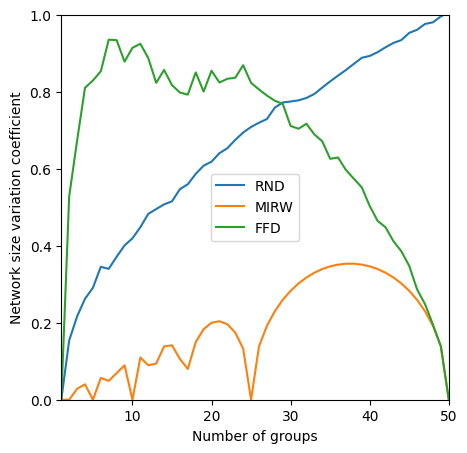

In [14]:
plt.figure(figsize=(5,5))

plt.plot(nb_groups, varcoefs_rnd, label='RND')
plt.plot(nb_groups, varcoefs_mirw, label='MIRW')
plt.plot(nb_groups, varcoefs_ffd, label='FFD')
plt.xlabel('Number of groups')
plt.ylabel('Network size variation coefficient')
plt.xlim(1,50)
plt.ylim(0,1)
plt.legend()

In [23]:
NB_GROUPS = 10
ALGO = 'MIRW'

In [24]:
print('\nPerforming graph division:', ALGO, '\t\tNumber of repetitions:', NB_REPETITIONS)

varcoef_dict = {
    'Timestamp':[],
    'VC AD':[],
    'VC ACC':[],
    'VC ABC':[]
}


for rep in range(NB_REPETITIONS):
    swarm_data[0].reset_groups()
    groups = swarm_data[0].MIRW(n=NB_GROUPS, s=rep+1, by_id=True)# <==================== ALGO CHOICE 

    group_assignment = {}
    for node in swarm_data[0].nodes:
        group_assignment[node.id] = node.group
    
    with tqdm(total=REVOLUTION/SAMPLE_STEP, desc='Varcoef computation '+str(rep)) as pbar:
        for t in np.arange(0, REVOLUTION, SAMPLE_STEP):
            graph = topo_graphs[t]

            group_ad = [] # List(mean degree of group)
            group_acc = []
            group_abc = []

            for group_id, node_list in groups.items():
                if len(node_list)>0:
                    group_ad.append(np.mean(nx.degree(graph, node_list)))
                    group_acc.append(nx.average_clustering(graph, node_list))
                    bc_dict = nx.betweenness_centrality(graph)
                    group_abc.append(np.mean([bc_dict[i] for i in node_list]))
                
            vc_ad = variation_coef(group_ad, ref_ad[int(t/SAMPLE_STEP)]) 
            vc_acc = variation_coef(group_acc, ref_acc[int(t/SAMPLE_STEP)]) 
            vc_abc = variation_coef(group_abc, ref_abc[int(t/SAMPLE_STEP)]) 
            
            varcoef_dict['Timestamp'].append(t)
            varcoef_dict['VC AD'].append(vc_ad)
            varcoef_dict['VC ACC'].append(vc_acc)
            varcoef_dict['VC ABC'].append(vc_abc)
            
            pbar.update(1)
            
            
df = pd.DataFrame(varcoef_dict)
df = df.groupby('Timestamp').mean()
filename = 'sat50_varcoefs_'+ALGO+'_sampled'+str(SAMPLE_STEP)+'_rep'+str(NB_REPETITIONS)+'_mean.csv'
print('\nExporting to', EXPORT_PATH+filename)
df.to_csv(EXPORT_PATH+filename, sep=',')


Performing graph division: MIRW 		Number of repetitions: 30


Varcoef computation 0: 100%|██████████| 150/150.0 [00:08<00:00, 16.91it/s]
Varcoef computation 1: 100%|██████████| 150/150.0 [00:08<00:00, 16.83it/s]
Varcoef computation 2: 100%|██████████| 150/150.0 [00:08<00:00, 16.75it/s]
Varcoef computation 3: 100%|██████████| 150/150.0 [00:08<00:00, 16.94it/s]
Varcoef computation 4: 100%|██████████| 150/150.0 [00:08<00:00, 16.84it/s]
Varcoef computation 5: 100%|██████████| 150/150.0 [00:08<00:00, 16.93it/s]
Varcoef computation 6: 100%|██████████| 150/150.0 [00:08<00:00, 16.82it/s]
Varcoef computation 7: 100%|██████████| 150/150.0 [00:08<00:00, 16.99it/s]
Varcoef computation 8: 100%|██████████| 150/150.0 [00:08<00:00, 17.01it/s]
Varcoef computation 9: 100%|██████████| 150/150.0 [00:08<00:00, 16.93it/s]
Varcoef computation 10: 100%|██████████| 150/150.0 [00:08<00:00, 16.92it/s]
Varcoef computation 11: 100%|██████████| 150/150.0 [00:08<00:00, 16.86it/s]
Varcoef computation 12: 100%|██████████| 150/150.0 [00:08<00:00, 17.02it/s]
Varcoef computation 13


Exporting to ..\output\data\sat50_varcoefs_MIRW_sampled12_rep30_mean.csv


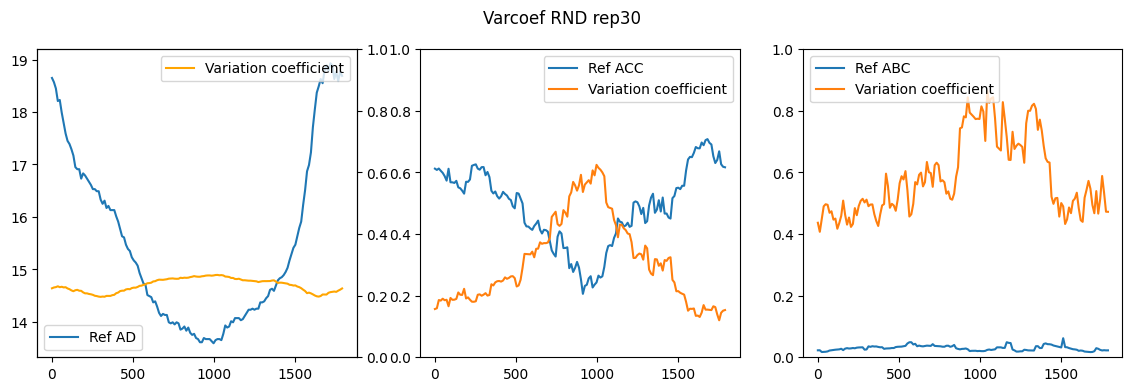

In [30]:
fig, axes = plt.subplots(figsize=(14,4), ncols=3)
fig.suptitle('Varcoef RND rep30')

ax = axes[0]
ax.plot(idx, ref_ad, label='Ref AD')
ax.legend()
ax2 = ax.twinx()
ax2.plot(idx, df['VC AD'], c='orange', label='Variation coefficient')
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_ylim(0,1)
ax2.legend()

ax = axes[1]
ax.plot(idx, ref_acc, label='Ref ACC')
ax.plot(idx, df['VC ACC'], label='Variation coefficient')
ax.set_ylim(0,1)
ax.legend()

ax = axes[2]
ax.plot(idx, ref_abc, label='Ref ABC')
ax.plot(idx, df['VC ABC'], label='Variation coefficient')
ax.set_ylim(0,1)
ax.legend()